In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, mean_squared_error

In [2]:
df = pd.read_csv('clean_kaggle_data_2022.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


In [4]:
df.shape

(8137, 298)

# Data Cleaning

## Clean NaN

In [5]:
# See how many null values are in each column
number_null = df.isnull().sum(axis=0)
print(number_null)

Duration (in seconds)       0
Q2                          0
Q3                          0
Q4                          0
Q5                          0
                         ... 
Q44_10                   7370
Q44_11                   7731
Q44_12                   7820
Q29_Encoded                 1
Q29_buckets                 1
Length: 298, dtype: int64


In [6]:
number_null.loc[number_null != 0]

Q6_1           4374
Q6_2           7018
Q6_3           5756
Q6_4           6679
Q6_5           7663
               ... 
Q44_10         7370
Q44_11         7731
Q44_12         7820
Q29_Encoded       1
Q29_buckets       1
Length: 285, dtype: int64

There are 285 columns that have NaN values.

If a feature has lots of data are null(for here is a question contains lots of answers are NaN), (or it has lot of missing values), it doesn't provide useful and enough information either for people understand the meaning or for classification.

Although we can fill the missing value with some specific value, the overall validate, meaningful and useful data of that feature does not supprot enough inforamtion for us to have a meaningful and useful value to fill the missing value.

The reason why we choose 30% as a threshold is that:

Theoretically, 25 to 30% is the maximum missing values are allowed or reasonable to keep the feature(variable), beyond which we might want to drop the variable from analysis. If the missing value is more than 30%, I think the feature data does not provide enough and useful information for us, and we can think it as the not useful feature and drop it.

In [7]:
# Drop the columns that have more than 30% null values (missing values) 

for i in df.columns:
    if df[i].isnull().sum() > 0.3 * df.shape[0]:
        df = df.drop(i, axis=1)

In [8]:
df.shape

(8137, 18)

In [9]:
df.columns

Index(['Duration (in seconds)', 'Q2', 'Q3', 'Q4', 'Q5', 'Q8', 'Q11', 'Q12_1',
       'Q16', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q29', 'Q30', 'Q29_Encoded',
       'Q29_buckets'],
      dtype='object')

In [10]:
df['Q12_1'].unique()

array(['What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
       'Python', nan], dtype=object)

We can find that in the original data many question answers(reponses) are divided into different parts. This makes one question leads to several columns in the dataset. For example, for Q6, we have Q6_1, Q6_2, Q6_3... .
And after we drop some columns by the rules and threshold above, we have 18 columns left.

Q12: What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice

Q12_1: What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python

In these 18 columns, we have a column 'Q12_1'. But for Q12, we now have the Q12_1 only and we have dropped other columns about Q12 (e.g. Q12_2, Q12_3...). In Q12_1, we only have responses with 'Python' and 'nan'. Other response, like R or Matlab, are in other columns which are about Q12. So if we use this Q12_1 column only and fill the nan with its mode which is Python, and then apply this feature data to machine learning model, it will lead to a model that is unfair and with not enough, useful information. The model will have the bias.

So, I decide to drop the column 'Q12_1' to prevent to a bias model due to feature Q12. And only study and build the model with the remaining columns' data (features' data).

And also for all the remaining columns (features), each of them has more than 5000 datapoints. Each of them has 8147 datapoints.

In [11]:
# Drop the 'Q12_1'
df.drop(['Q12_1'], axis=1, inplace=True)
df.shape

(8137, 17)

Now we have 17 columns and each column has 8136 datapoints (there is another one row with question content). We need to check whether each column has NaN values.

In [12]:
df.isnull().sum()

Duration (in seconds)      0
Q2                         0
Q3                         0
Q4                         0
Q5                         0
Q8                         0
Q11                        0
Q16                      684
Q23                        0
Q24                        0
Q25                        0
Q26                        0
Q27                        0
Q29                        0
Q30                       50
Q29_Encoded                1
Q29_buckets                1
dtype: int64

To decide which useful and appropriate method we need to use to fill the missing value, based on the learn from tutorial 6, we can start with data exploration - can check if there a pattern in where the NaN values appear or if the rows with NaN are randomly distributed.

In [13]:
for i in df.columns:
    print(i,df[i][0])

Duration (in seconds) Duration (in seconds)
Q2 What is your age (# years)?
Q3 What is your gender? - Selected Choice
Q4 In which country do you currently reside?
Q5 Are you currently a student? (high school, university, or graduate)
Q8 What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Q11 For how many years have you been writing code and/or programming?
Q16 For how many years have you used machine learning methods?
Q23 Select the title most similar to your current role (or most recent title if retired): - Selected Choice
Q24 In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice
Q25 What is the size of the company where you are employed?
Q26 Approximately how many individuals are responsible for data science workloads at your place of business?
Q27 Does your current employer incorporate machine learning methods into their business?
Q29 What is your current yearly compe

In [14]:
df.Q11.value_counts()

1-3 years                                                            1468
5-10 years                                                           1394
3-5 years                                                            1243
10-20 years                                                          1155
< 1 years                                                            1148
20+ years                                                            1044
I have never written code                                             684
For how many years have you been writing code and/or programming?       1
Name: Q11, dtype: int64

In [15]:
df.Q16.value_counts()

Under 1 year                                                  1724
1-2 years                                                     1266
I do not use machine learning methods                         1107
2-3 years                                                      955
5-10 years                                                     808
4-5 years                                                      635
3-4 years                                                      591
10-20 years                                                    366
For how many years have you used machine learning methods?       1
Name: Q16, dtype: int64

In [16]:
df.Q29.value_counts()

$0-999                                                          1112
10,000-14,999                                                    493
30,000-39,999                                                    464
1,000-1,999                                                      444
40,000-49,999                                                    421
100,000-124,999                                                  404
5,000-7,499                                                      391
50,000-59,999                                                    366
7,500-9,999                                                      362
150,000-199,999                                                  342
20,000-24,999                                                    337
60,000-69,999                                                    318
15,000-19,999                                                    299
70,000-79,999                                                    289
25,000-29,999                     

In [17]:
df.Q30.value_counts()

$0 ($USD)                                                                                                                                                                           2653
$100-$999                                                                                                                                                                           1993
$1000-$9,999                                                                                                                                                                        1412
$1-$99                                                                                                                                                                              1401
$10,000-$99,999                                                                                                                                                                      453
$100,000 or more ($USD)                                                    

At beginning, I want to find some relationship between Q11 & Q16, Q29 & Q30:

Q11:For how many years have you been writing code and/or programming?

Q16:For how many years have you used machine learning methods?

Q11 & Q16: may be someone fill Q11 and they write code about machine learning all the time, so they did't fill Q16

Q29 What is your current yearly compensation (approximate $USD)?

Q30 Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?

Q29 & Q30: may be the people with higher current yearly compensation spent more money on learning

But it seems there is not enough information to find it clearly or ensure there is a relationship between Q11 & Q16, Q29 & Q30.

In [18]:
print(df.Q16.isnull().sum() / (len(df.Q16)-1))
print(df.Q30.isnull().sum() / (len(df.Q30)-1))

0.084070796460177
0.006145526057030482


We find that the percentage that the NaN value has in their corresponding column is below 1%. So they will not make a great influence to the result and the model. 
And the difference between the first two values with the largest number for Q16 and Q30 is not very small. Although we fill the NaN value with the mode value, it will not make the model has much bias to the value with largest number.
So we can use mode method to fill the NaN values for Q16 and Q30.

In [19]:
df['Q16'].fillna(df['Q16'].mode()[0],inplace=True)
df['Q30'].fillna(df['Q30'].mode()[0],inplace=True)

In [20]:
df

,Duration (in seconds),Q2,Q3,Q4,Q5,Q8,Q11,Q16,Q23,Q24,Q25,Q26,Q27,Q29,Q30,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",What is the highest level of formal education ...,For how many years have you been writing code ...,For how many years have you used machine learn...,Select the title most similar to your current ...,In what industry is your current employer/cont...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,NaN,NaN
1,851,55-59,Man,France,No,Some college/university study without earning ...,10-20 years,1-2 years,Data Scientist,Online Service/Internet-based Services,0-49 employees,1-2,"We recently started using ML methods (i.e., mo...","25,000-29,999","$1000-$9,999",2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Bachelor’s degree,10-20 years,4-5 years,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...","100,000-124,999",$0 ($USD),10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Doctoral degree,20+ years,5-10 years,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...","100,000-124,999",$100-$999,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Doctoral degree,10-20 years,5-10 years,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","200,000-249,999",$100-$999,13.0,"200,000-299,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,540,40-44,Man,United States of America,No,Master’s degree,10-20 years,Under 1 year,Data Architect,Accounting/Finance,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...","100,000-124,999",$0 ($USD),10.0,"100,000-124,999"
8133,603,35-39,Man,India,No,Master’s degree,1-3 years,1-2 years,Data Scientist,Broadcasting/Communications,"10,000 or more employees",1-2,"We have well established ML methods (i.e., mod...","2,000-2,999",$100-$999,0.0,"0-9,999"
8134,557,40-44,Man,India,No,Bachelor’s degree,1-3 years,I do not use machine learning methods,Data Engineer,Computers/Technology,0-49 employees,0,No (we do not use ML methods),$0-999,$1-$99,0.0,"0-9,999"
8135,860,25-29,Man,Turkey,No,Master’s degree,< 1 years,Under 1 year,Engineer (non-software),Energy/Mining,"10,000 or more employees",0,No (we do not use ML methods),"25,000-29,999",$100-$999,2.0,"20,000-29,999"


## convert categorical data into numerical data by encoding

Duration (in seconds) Duration (in seconds)

Q2 What is your age (# years)?

Q3 What is your gender? - Selected Choice

Q4 In which country do you currently reside?

Q5 Are you currently a student? (high school, university, or graduate)

Q8 What is the highest level of formal education that you have attained or plan to attain within the next 2 years?

Q11 For how many years have you been writing code and/or programming?

Q16 For how many years have you used machine learning methods?

Q23 Select the title most similar to your current role (or most recent title if retired): - Selected Choice

Q24 In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice

Q25 What is the size of the company where you are employed?

Q26 Approximately how many individuals are responsible for data science workloads at your place of business?

Q27 Does your current employer incorporate machine learning methods into their business?

Q29 What is your current yearly compensation (approximate $USD)?

Q30 Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?
 (approximate $USD)?
 
Q29_Encoded nan
Q29_buckets nan


We now know and have what question is for each column, so we can drop the first row which is the question content for each column(feature). This will help us decrease one variable after we converting data.

In [21]:
df = df[1:]

In [22]:
df

,Duration (in seconds),Q2,Q3,Q4,Q5,Q8,Q11,Q16,Q23,Q24,Q25,Q26,Q27,Q29,Q30,Q29_Encoded,Q29_buckets
1,851,55-59,Man,France,No,Some college/university study without earning ...,10-20 years,1-2 years,Data Scientist,Online Service/Internet-based Services,0-49 employees,1-2,"We recently started using ML methods (i.e., mo...","25,000-29,999","$1000-$9,999",2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Bachelor’s degree,10-20 years,4-5 years,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...","100,000-124,999",$0 ($USD),10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Doctoral degree,20+ years,5-10 years,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...","100,000-124,999",$100-$999,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Doctoral degree,10-20 years,5-10 years,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","200,000-249,999",$100-$999,13.0,"200,000-299,999"
5,679,40-44,Man,United States of America,No,Master’s degree,10-20 years,5-10 years,Data Scientist,Computers/Technology,"1000-9,999 employees",3-4,"We have well established ML methods (i.e., mod...","200,000-249,999","$100,000 or more ($USD)",13.0,"200,000-299,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,540,40-44,Man,United States of America,No,Master’s degree,10-20 years,Under 1 year,Data Architect,Accounting/Finance,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...","100,000-124,999",$0 ($USD),10.0,"100,000-124,999"
8133,603,35-39,Man,India,No,Master’s degree,1-3 years,1-2 years,Data Scientist,Broadcasting/Communications,"10,000 or more employees",1-2,"We have well established ML methods (i.e., mod...","2,000-2,999",$100-$999,0.0,"0-9,999"
8134,557,40-44,Man,India,No,Bachelor’s degree,1-3 years,I do not use machine learning methods,Data Engineer,Computers/Technology,0-49 employees,0,No (we do not use ML methods),$0-999,$1-$99,0.0,"0-9,999"
8135,860,25-29,Man,Turkey,No,Master’s degree,< 1 years,Under 1 year,Engineer (non-software),Energy/Mining,"10,000 or more employees",0,No (we do not use ML methods),"25,000-29,999",$100-$999,2.0,"20,000-29,999"


### Nominal Data

For the features(columns) that are catrgorical and nomial,
we use Dummy Encoding for Q3, Q4, Q5, Q23, Q24, Q27. It is similar to one-hot encoding. It transforms the catorical variable into a set of binary variables (True, False). It uses N-1 dummy variabels to represent N categories, since N-1 dummy variables can indicate the very last kind of dummy variable. However, Dummy Enocoding will increase the number of features.

Q3 Gender,

Q4 Country,

Q5 Are you currently a student?,

Q23 Title most similar to your current role,

Q24 What industry is your current employer/contract,

Q27 Does your current employer incorporate machine learning methods into their business?

In [23]:
# Dummy for Q3 Gender
gender = pd.get_dummies(data=df.Q3, prefix = 'Q3')
df = pd.concat([df.drop(['Q3'], axis=1),gender], axis = 1)

In [24]:
# Dummy for Q4 Country
Country = pd.get_dummies(data = df.Q4, prefix = 'Q4')
df = pd.concat([df.drop(['Q4'], axis=1), Country], axis = 1)

In [25]:
# Dummy for Q5 Are you currently a student?
currently_student = pd.get_dummies(data=df.Q5, prefix = 'Q5')
df = pd.concat([df.drop(['Q5'], axis=1),currently_student], axis = 1)

In [26]:
# Dummy for Q23 Title most similar to your current role
title  = pd.get_dummies(data=df.Q23, prefix = 'Q23')
df = pd.concat([df.drop(['Q23'], axis=1),title], axis = 1)

In [27]:
# Dummy for Q24 What industry is your current employer/contract
industry  = pd.get_dummies(data=df.Q24, prefix = 'Q24')
df = pd.concat([df.drop(['Q24'], axis=1),industry], axis = 1)

In [28]:
# Dummy for Q27 Does your current employer incorporate machine learning methods into their business?
employer_machine  = pd.get_dummies(data=df.Q27, prefix = 'Q27')
df = pd.concat([df.drop(['Q27'], axis=1),employer_machine], axis = 1)

### Ordinal Data

For the remaining features(columns) that are categorical and ordinal or have an inherent order, we use OrdinalEncoder for Q2, Q8, Q11, Q16, Q25, Q26, Q30. For these ordinal data, preserving the order is important. So the coding should reflect the order. In label encoding, each label is converted to an integer value. And for the encoding for each feature, I will create a variable that contains category values.

Q2 Age

Q8 Highest level of formal education

Q11 Years writing code

Q16 Years use machine learning

Q25 Size of Company

Q26 Number of responsibile for data

Q30 Money spent on machine learning

Encode for Q2 Age

In [29]:
df.Q2.value_counts()

25-29    1604
30-34    1430
35-39    1207
40-44    1037
22-24     743
45-49     701
50-54     567
55-59     359
60-69     341
18-21      83
70+        64
Name: Q2, dtype: int64

In [30]:
encoder_Q2= ce.OrdinalEncoder(cols=['Q2'], return_df=True,
                           mapping=[{'col':'Q2',
          'mapping':{'18-21':0,
                     '22-24':1,
                     '25-29':2,
                     '30-34':3,
                     '35-39':4,
                     '40-44':5, 
                     '45-49':6, 
                     '50-54':7, 
                     '55-59':8, 
                     '60-69':9,
                     '70+':10}}])
Q2_encoding = encoder_Q2.fit_transform(df.Q2)
df.Q2 = Q2_encoding

Encode for Q8 Highest level of formal education

In [31]:
df.Q8.value_counts()

Master’s degree                                                      3567
Bachelor’s degree                                                    2005
Doctoral degree                                                      1349
I prefer not to answer                                                426
Some college/university study without earning a bachelor’s degree     304
Professional doctorate                                                279
No formal education past high school                                  206
Name: Q8, dtype: int64

In [32]:
encoder_Q8= ce.OrdinalEncoder(cols=['Q8'], return_df=True,
                           mapping=[{'col':'Q8',
          'mapping':{'I prefer not to answer':0,
                     'No formal education past high school':1,
                     'Some college/university study without earning a bachelor’s degree':2,
                     'Bachelor’s degree':3,
                     'Master’s degree':4,
                     'Doctoral degree':5, 
                     'Professional doctorate': 6}}])
Q8_encoding = encoder_Q8.fit_transform(df.Q8)
df.Q8 = Q8_encoding

Encode for Q11 Years writing code

In [33]:
df.Q11.value_counts()

1-3 years                    1468
5-10 years                   1394
3-5 years                    1243
10-20 years                  1155
< 1 years                    1148
20+ years                    1044
I have never written code     684
Name: Q11, dtype: int64

In [34]:
encoder_Q11= ce.OrdinalEncoder(cols=['Q11'], return_df=True,
                           mapping=[{'col':'Q11',
          'mapping':{'I have never written code':0,
                     '< 1 years':1,
                     '1-3 years':2,
                     '3-5 years':3,
                     '5-10 years':4,
                     '10-20 years':5,
                     '20+ years':6}}])
Q11_encoding = encoder_Q11.fit_transform(df.Q11)
df.Q11 = Q11_encoding

Encode for Q16 Years use machine learning

In [35]:
df.Q16.value_counts()

Under 1 year                             2408
1-2 years                                1266
I do not use machine learning methods    1107
2-3 years                                 955
5-10 years                                808
4-5 years                                 635
3-4 years                                 591
10-20 years                               366
Name: Q16, dtype: int64

In [36]:
encoder_Q16= ce.OrdinalEncoder(cols=['Q16'], return_df=True,
                           mapping=[{'col':'Q16',
          'mapping':{'I do not use machine learning methods':0,
                     'Under 1 year':1,
                     '1-2 years':2,
                     '2-3 years':3,
                     '3-4 years':4,
                     '4-5 years':5,
                     '5-10 years':6,
                     '10-20 years':7}}])
Q16_encoding = encoder_Q16.fit_transform(df.Q16)
df.Q16 = Q16_encoding

Encode for Q25 Size of Company

In [37]:
df.Q25.value_counts()

10,000 or more employees    1914
0-49 employees              1859
1000-9,999 employees        1711
50-249 employees            1429
250-999 employees           1223
Name: Q25, dtype: int64

In [38]:
encoder_Q25= ce.OrdinalEncoder(cols=['Q25'], return_df=True,
                           mapping=[{'col':'Q25',
          'mapping':{'0-49 employees':0,
                     '50-249 employees':1,
                     '250-999 employees':2,
                     '1000-9,999 employees':3,
                     '10,000 or more employees':4}}])
Q25_encoding = encoder_Q25.fit_transform(df.Q25)
df.Q25 = Q25_encoding

Encode for Q26 Number of responsibile FOR data

In [39]:
df.Q26.value_counts()

20+      2061
1-2      1658
0        1298
3-4      1257
5-9      1029
10-14     595
15-19     238
Name: Q26, dtype: int64

In [40]:
encoder_Q26= ce.OrdinalEncoder(cols=['Q26'], return_df=True,
                           mapping=[{'col':'Q26',
          'mapping':{'0':0,
                     '1-2':1,
                     '3-4':2,
                     '5-9':3,
                     '10-14':4, 
                     '15-19':5, 
                     '20+':6}}])
Q26_encoding = encoder_Q26.fit_transform(df.Q26)
df.Q26 = Q26_encoding

Encode for Q30 Money spent on machine learning

In [41]:
df.Q30.value_counts()

$0 ($USD)                  2703
$100-$999                  1993
$1000-$9,999               1412
$1-$99                     1401
$10,000-$99,999             453
$100,000 or more ($USD)     174
Name: Q30, dtype: int64

In [42]:
encoder_Q30= ce.OrdinalEncoder(cols=['Q30'], return_df=True,
                           mapping=[{'col':'Q30',
          'mapping':{'$0 ($USD)':0,
                     '$1-$99':1,
                     '$100-$999':2,
                     '$1000-$9,999':3,
                     '$10,000-$99,999':4, 
                     '$100,000 or more ($USD)':5}}])
Q30_encoding = encoder_Q30.fit_transform(df.Q30)
df.Q30 = Q30_encoding

In [43]:
df

,Duration (in seconds),Q2,Q8,Q11,Q16,Q25,Q26,Q29,Q30,Q29_Encoded,...,Q24_Online Service/Internet-based Services,Q24_Other,Q24_Retail/Sales,Q24_Shipping/Transportation,Q27_I do not know,Q27_No (we do not use ML methods),Q27_We are exploring ML methods (and may one day put a model into production),"Q27_We have well established ML methods (i.e., models in production for more than 2 years)","Q27_We recently started using ML methods (i.e., models in production for less than 2 years)",Q27_We use ML methods for generating insights (but do not put working models into production)
1,851,8,2,5,2,0,1,"25,000-29,999",3,2.0,...,1,0,0,0,0,0,0,0,1,0
2,501,3,3,5,5,2,6,"100,000-124,999",0,10.0,...,0,0,0,0,0,0,0,1,0,0
3,787,10,5,6,6,3,6,"100,000-124,999",2,10.0,...,0,0,0,0,0,0,0,0,1,0
4,1132,5,5,5,6,3,6,"200,000-249,999",2,13.0,...,0,0,0,0,0,0,0,1,0,0
5,679,5,4,5,6,3,2,"200,000-249,999",5,13.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,540,5,4,5,1,4,6,"100,000-124,999",0,10.0,...,0,0,0,0,0,0,0,1,0,0
8133,603,4,4,2,2,4,1,"2,000-2,999",2,0.0,...,0,0,0,0,0,0,0,1,0,0
8134,557,5,3,2,0,0,0,$0-999,1,0.0,...,0,0,0,0,0,1,0,0,0,0
8135,860,2,4,1,1,4,0,"25,000-29,999",2,2.0,...,0,0,0,0,0,1,0,0,0,0


# Exploratory data analysis and feature selection

Feature Engineering is the process that use domain knowledge to extract and organize the important features from the raw data. Its goal is to improve the model accuracy and the machine learning result by using these extracted features to train the machine learning model. The extracted features that are selected fit the purpose of the machine learning model. 


With using of extracted features by feature engineering in machine learning, it helps enhance the efficiency of the model, make easier algorithms that fit the data, make easier for algorithms to detect patterns in the data and have greater flexibility of the features.

For our problem, feature engineering help us to select features that are important with high feature importance and correlation with feature yearly compensation. So that we can build better model by selected features and predict with good results.

## Regularized Regression

In [44]:
df_Q29 = pd.concat([df.Q29, df.Q29_buckets], axis=1)
df.drop(['Q29', 'Q29_buckets'], axis=1, inplace=True)

In [45]:
X = df.drop(['Q29_Encoded'], axis=1)
Y = df.Q29_Encoded

In [46]:
# Split Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=21)

Some machine learning models are based on the Euclidean Distances. As a result, different scales by different features will lead to bias. The greater the scale is, the greater impact it has on the model and the result.
So, in order to avoid the bias that different scales generate, we can apply scaling on the data. So that all the features have the same scale.

In [47]:
# Normalization data
scaler = StandardScaler()
X_train_normalized = scaler.fit(X_train).transform(X_train)
X_test_normalized = scaler.fit(X_train).transform(X_test)

## Lasso Regularization to feature selection

We use Lasso Regularization method to find the relationships between a feature and yearly compensation. To find the best one, we use Gridsearch to find the best alpha value. 

In [48]:
# Use Lasso and find the best parameter value by using Gridsearch
reg = linear_model.Lasso(random_state=21)
# Parameter set to test
parameter_set = {'alpha':[0.1,10,1]}
# Gridsearch
score = make_scorer(r2_score)
grid = GridSearchCV(reg, parameter_set, scoring = score)
grid = grid.fit(X_train,Y_train)
# Select the one with best parameters
reg_best_grid = grid.best_estimator_

# Print the best one with corresponding paramter values
print(reg_best_grid)

Lasso(alpha=0.1, random_state=21)


In [49]:
reg_best_grid.score(X_train,Y_train)

0.5364549325914263

After we find the best alpha value, we get the best model. Now we can compute the feature importance for each feature.

In [50]:
# Feature importance
feature_importance = reg_best_grid.coef_
print(feature_importance)

[-6.56428137e-07  1.79965555e-01  6.48110586e-02  3.42679510e-01
  2.71998246e-01  1.09583677e-01  1.75268641e-01  3.84707326e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -6.72531735e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000

Use the feature importance to select the features that are kept and dropped.

Drop the column with 0 value of feature importance.

Keep the column with non-zero value of feature importance.

Also, drop the column that with 0 value of feature importance for train and test data.

In [51]:
drop_list = []
drop_index = []
keep_list = []
keep_index = []
feature_importance_selected = []

X_selected = X
X_train_selected = X_train
X_test_selected = X_test

for i in range(len(feature_importance)):
    if feature_importance[i] == 0:
        drop_list.append(X.columns[i])
        drop_index.append(i)
        X_selected = X_selected.drop([X.columns[i]], axis = 1)
        X_train_selected = X_train_selected.drop([X.columns[i]], axis = 1)
        X_test_selected = X_test_selected.drop([X.columns[i]], axis = 1)
    else:
        keep_list.append(X.columns[i]) 
        keep_index.append(i)
        feature_importance_selected.append(feature_importance[i])

In [52]:
# Feature importance of 'Duration (in seconds)'
print(feature_importance[0])

-6.564281367492947e-07


We can find that the feature importance for the first feature 'Duration (in seconds)' is -6.564281367492947e-07. It's very small and almost nearly 0. So we can say that this feature actually not really has a great relationship with the yearly compensation. So we can dropped it.

In [53]:
X_selected.drop(['Duration (in seconds)'], axis=1, inplace=True)
X_train_selected.drop(['Duration (in seconds)'], axis=1, inplace=True)
X_test_selected.drop(['Duration (in seconds)'], axis=1, inplace=True)

In [54]:
print('Number of dropped feature:',len(drop_list)+1)
print(X_selected.shape)
print(X_selected.columns)

Number of dropped feature: 95
(8136, 12)
Index(['Q2', 'Q8', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q4_India',
       'Q4_United States of America',
       'Q23_Manager (Program, Project, Operations, Executive-level, etc)',
       'Q24_Academics/Education',
       'Q27_We have well established ML methods (i.e., models in production for more than 2 years)'],
      dtype='object')


In [55]:
keep_list.remove('Duration (in seconds)')
keep_index.remove(keep_index[0])
feature_importance_selected.remove(feature_importance_selected[0])

print('Number of kept feature', len(keep_index))

Number of kept feature 12


These are the columns that we kept now:

Q2 What is your age (# years)?

Q4 In which country do you currently reside?

Q8 What is the highest level of formal education that you have attained or plan to attain within the next 2 years?

Q11 For how many years have you been writing code and/or programming?

Q16 For how many years have you used machine learning methods?

Q23 Select the title most similar to your current role (or most recent title if retired): - Selected Choice

Q24 In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice

Q25 What is the size of the company where you are employed?

Q26 Approximately how many individuals are responsible for data science workloads at your place of business?

Q27 Does your current employer incorporate machine learning methods into their business?

Q30 Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?
 (approximate $USD)?

## Exploratory data analysis

### Visualize the order of feature importance

After the encoding and select the most important features by feature selection, now we do exploratory data analysis.

([<matplotlib.axis.XTick at 0x7f97a8566a30>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '33'),
  Text(8, 0, '68'),
  Text(9, 0, '80'),
  Text(10, 0, '86'),
  Text(11, 0, '104')])

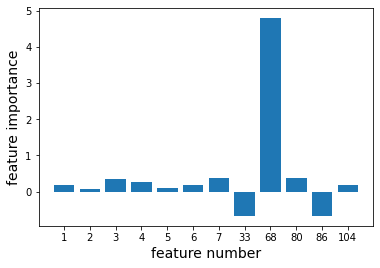

In [56]:
# Plot the feature importance
plt.bar(range(len(feature_importance_selected)),feature_importance_selected)
plt.xlabel('feature number', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.xticks(range(len(feature_importance_selected)), keep_index)

In [57]:
feature_importance_selected_list = pd.DataFrame({'importance':feature_importance_selected, 'feature number': keep_index})
feature_importance_selected_list.sort_values(by=['importance'])

,importance,feature number
7,-0.672532,33
10,-0.672321,86
1,0.064811,2
4,0.109584,5
5,0.175269,6
0,0.179966,1
11,0.185868,104
3,0.271998,4
2,0.342680,3
9,0.384223,80


In [58]:
print(X.columns[68], feature_importance[68])
print(X.columns[2], feature_importance[2])

Q4_United States of America 4.79713440964163
Q8 0.06481105858665537


In [59]:
feature_importance[33] < feature_importance[86]

True

In [60]:
print(X.columns[33], feature_importance[33])
print(X.columns[86], feature_importance[86])

Q4_India -0.6725317351516281
Q24_Academics/Education -0.672320977505366


### Corrleation

We can also use Heatmap to look at the correlation between the features and the survey respondent’s yearly compensation.

We can mask the upper right triangle as they are identical to the lower left triangle. The diagonal also is irrelevant as its the correlation of a feature with itself, which correlation is equal to 1.

<AxesSubplot:>

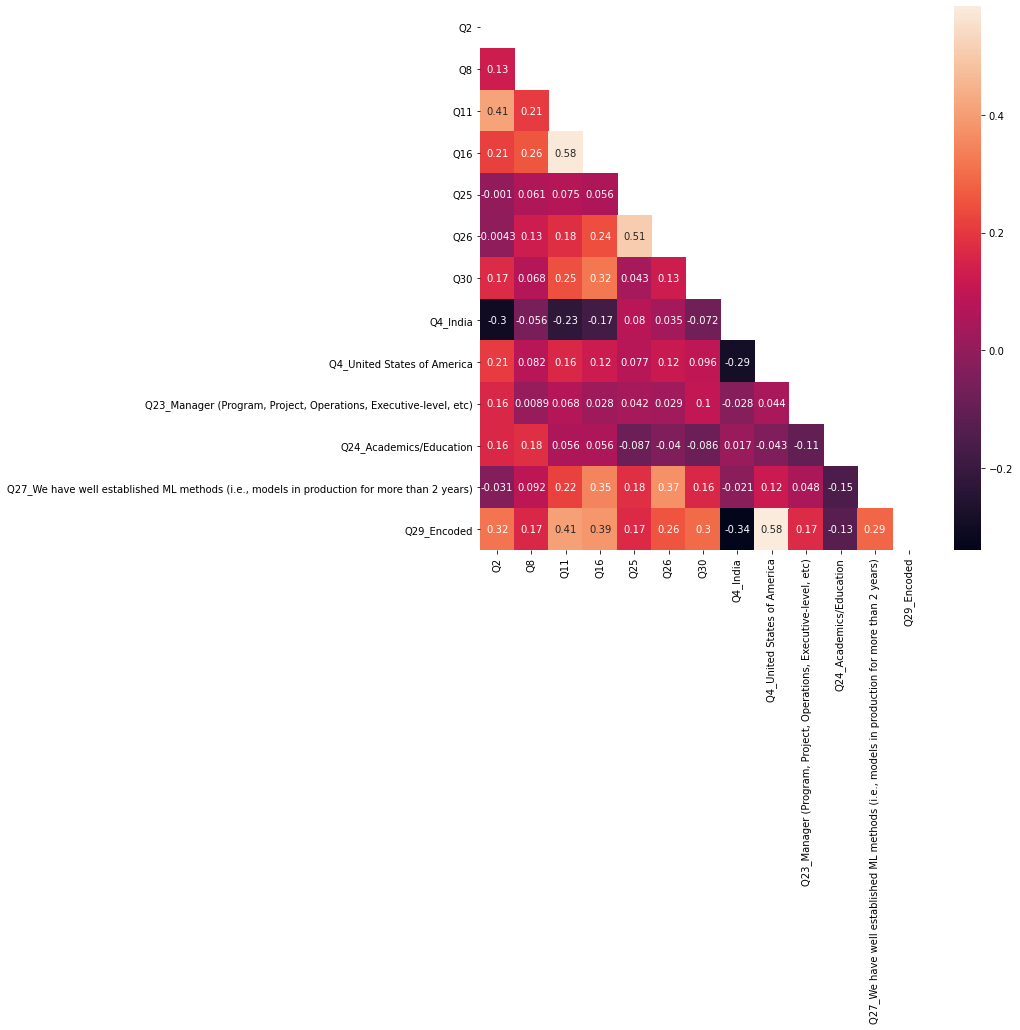

In [61]:
X_selected_Q29encoded = pd.concat([X_selected, df.Q29_Encoded], axis = 1)
mask = np.zeros_like(X_selected_Q29encoded.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (10,10))
sns.heatmap(X_selected_Q29encoded.corr(),mask = mask, annot = True)

In [62]:
X_selected_Q29encoded.corr()['Q29_Encoded'].sort_values()

Q4_India                                                                                     -0.339819
Q24_Academics/Education                                                                      -0.130247
Q8                                                                                            0.165013
Q25                                                                                           0.165711
Q23_Manager (Program, Project, Operations, Executive-level, etc)                              0.171829
Q26                                                                                           0.255693
Q27_We have well established ML methods (i.e., models in production for more than 2 years)    0.286738
Q30                                                                                           0.297743
Q2                                                                                            0.315812
Q16                                                                      

For the positive feature importance:

We can find that the feature 'Q4_United States of America' has the highest positive feature importance (Q4 is In which country do you currently reside?). Its feature importance value is 4.79713440964163. And the correlation between it and yearly compensation is 0.584453. These mean that it has the greatest (strongest) positive relationship with the yearly compensation among the selected features with positive feature importance and positive correlation.

The feature 'Q8' has the lowest positive feature importance (Q8 is What is the highest level of formal education that you have attained or plan to attain within the next 2 years?). Its feature importance value is 0.06481105858665537. And the correlation between it and yearly compensation is 0.165013
Thess mean that it has the lowest (weakest) positive relationship with the yearly compensation among the selected features with positive feature importance and positive correlation.

For the negative feature importance:

We can find that Q4_India has the highest negative feature importance value (Q4 is In which country do you currently reside?). Its feature importance value is -0.6725317351516281. And the correlation between it and yearly compensation is -0.339819. 
These mean that it has the greatest (strongest) negative relationship with the yearly compensation among the selected features with negative feature importance and negative correlation.

We can find that Q24_Academics/Education has the lowest negative feature importance value (Q24 is Q24 In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice). Its feature importance value is -0.672320977505366. And the correlation between it and yearly compensation is -0.130247.
These means that it has the lowest (weakest) negative relationship with the yearly compensation among the selected features with negative feature importance and negative correlation.

In [63]:
feature_importance_selected_abslist = pd.DataFrame({'importance':np.abs(feature_importance_selected), 'feature number': keep_index})
feature_importance_selected_abslist.sort_values(by=['importance'])

,importance,feature number
1,0.064811,2
4,0.109584,5
5,0.175269,6
0,0.179966,1
11,0.185868,104
3,0.271998,4
2,0.342680,3
9,0.384223,80
6,0.384707,7
10,0.672321,86


Also, feature 'Q4_United States of America' has the greatest absolute feature importance value. This indicates that reside and work in  United States of America is the most important factor that can affect the yearly compensation among the selected features. It has the strongest relationship with the yearly compensation among the selected features.

Feature 'Q8' has the lowest absolute feature importance value. This indicates that the highest level of formal education that respondents has or will have is the least important factor that can affect the yearly compensation among the selected features. It has the weakest relationship with the yearly compensation among the selected features.

Also Q4_India has non-zero feature importance and non-zero correlation with yearly compensation.
So, in the originial attributed in the data, 'Q4' is the most related to a survey resondent's yearly compenstaion. originial attributed in the data 

# Model implementation

2.1: Some machine learning models are based on the Euclidean Distances. As a result, differnet scales by different features will lead to bias. The greater the scale is, the greater impact it has on the model and the result. So, in order to avoid the bias that different scales generate, we can apply scaling on the data. So that all the features have the same scale.


As in 2.1 of this file, we have scaled the data and explain the reason why scaling is needed. And we also apply the technique on the testing and training data separately.

In [64]:
X_train_selected, X_test_selected, Y_train_selected, Y_test_selected = train_test_split(X_selected, Y,  test_size=0.3, random_state=21)
scaler = StandardScaler()
X_train_selected_norm = scaler.fit_transform(X_train_selected)
X_test_selected_norm = scaler.transform(X_test_selected)

In [65]:
Y_train_selected.value_counts()

0.0     2144
1.0      531
2.0      431
3.0      322
4.0      308
10.0     284
5.0      261
12.0     240
6.0      230
7.0      196
11.0     191
13.0     166
8.0      162
9.0      129
14.0     100
Name: Q29_Encoded, dtype: int64

In [66]:
len(Y_train_selected.value_counts())

15

In [67]:
def OrdinalLogistic(X_train, Y_train, X_test, logisitic_model):
    
    Y_train_ordinal = Y_train
    probability_cumulative = pd.DataFrame()
    probability_each = pd.DataFrame()
    predictions = []
    
    for i in range(14):
        yy = []
        probability_list = []
        for j in Y_train:
            if j > i:
                yy.append(int(1))
            else:
                yy.append(int(0))
        
        logisitic_model.fit(X_train, yy)
        
        probability = logisitic_model.predict_proba(X_test)
        
        for k in range(probability.shape[0]):
            probability_list.append(probability[k][0])
        
        probability_cumulative[i] = probability_list

    probability_cumulative[14] = [1]*len(probability)

    
    # calculate probability of each category
    for i in range(15):
        if i == 0 :
            probability_each[i] =  probability_cumulative[i]
        else:
            probability_each[i] =  probability_cumulative[i] - probability_cumulative[i-1]

    
    # indicate the predictions
    predictions = probability_each.idxmax(axis=1)
    
    return probability_cumulative, probability_each, predictions

In [68]:
logisitic_model = LogisticRegression(random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train_selected)
accuracy= np.zeros(10)
np_idx = 0


for train_idx, test_idx in kfold.split(X_train_selected):
    X_train, X_val = X_train_selected.values[train_idx], X_train_selected.values[test_idx]
    Y_train, Y_val = Y_train_selected.values[train_idx], Y_train_selected.values[test_idx]
    

    probability_cumulative, probability_each, predictions= OrdinalLogistic(X_train, Y_train, X_val,logisitic_model)

    TN = confusion_matrix(Y_val, predictions)[0][0]
    FP = confusion_matrix(Y_val, predictions)[0][1]
    FN = confusion_matrix(Y_val, predictions)[1][0]
    TP = confusion_matrix(Y_val, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))   

print ("Average Accuracy: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))
print('Standard deviation Accuracy: {}%'.format(np.std(accuracy)))

Fold 1: Accuracy: 78.571%
Fold 2: Accuracy: 82.422%
Fold 3: Accuracy: 81.25%
Fold 4: Accuracy: 81.2%
Fold 5: Accuracy: 84.462%
Fold 6: Accuracy: 79.92%
Fold 7: Accuracy: 77.016%
Fold 8: Accuracy: 78.125%
Fold 9: Accuracy: 82.156%
Fold 10: Accuracy: 78.788%
Average Accuracy: 80.391%(2.187%)
Standard deviation Accuracy: 2.1871048894778347%


As we using accuracy as metric and have 10-fold cross- validation, the average accuracy is 80.391%. Standard deviation is 2.1871048894778347%.

Below are the probability for each of the salary buckets and our prediction

In [69]:
# a probability of belonging to each of the salary buckets
probability_each

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.728536,0.076808,0.064447,0.026368,0.026495,0.034488,0.016895,0.009784,0.004780,0.003771,0.003397,0.002004,0.001098,0.000487,0.000642
1,0.534860,0.222627,0.109525,0.043763,0.024869,0.016772,0.011944,0.013987,0.003228,0.005306,0.005823,0.004050,0.001429,0.000508,0.001308
2,0.320269,0.111324,0.146466,0.099201,0.062100,0.083759,0.048317,0.052034,0.026311,0.019435,0.017504,0.007966,0.003280,0.000642,0.001393
3,0.688204,0.106593,0.078312,0.033715,0.024434,0.021773,0.015666,0.014566,0.006431,0.004262,0.002904,0.001955,0.000623,0.000042,0.000522
4,0.183138,0.075042,0.110240,0.095186,0.105581,0.121801,0.056572,0.076507,0.052128,0.013742,0.070685,0.021638,0.009426,0.005105,0.003210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.543601,0.122305,0.077740,0.058495,0.055410,0.045592,0.033154,0.020805,0.012338,0.007603,0.013161,0.004317,0.001784,0.001617,0.002078
565,0.490342,0.125381,0.142243,0.063207,0.056482,0.057381,0.017620,0.018973,0.010215,0.006816,0.006057,0.002155,0.001511,-0.000107,0.001725
566,0.719986,0.152888,0.057244,0.020286,0.016976,0.008315,0.006543,0.004741,0.001621,0.001647,0.002722,0.002137,0.000236,0.001494,0.003164
567,0.167921,0.036796,0.031335,0.036515,0.087398,0.079492,0.119333,0.104540,0.073876,0.051502,0.105722,0.062463,0.026470,0.011251,0.005386


In [70]:
# The prediction
predictions

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    0
Length: 569, dtype: int64

We change the value of C (hyperparameter). And treat each value of hyperparameter(s) as a new model.

In [71]:
# Change C value
logisitic_model = LogisticRegression(random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)
bias_list = []
variance_list = []

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
        model = LogisticRegression(C=C, random_state=21, max_iter = 1000)
        np_idx = 0
        bias_C = []
        variation_C =[]
        print('C =',C)
        for train_idx, test_idx in kfold.split(X_train_selected):
            X_train, X_val = X_train_selected.values[train_idx], X_train_selected.values[test_idx]
            Y_train, Y_val = Y_train_selected.values[train_idx], Y_train_selected.values[test_idx]
    
            probability_cumulative, probability_each, predictions= OrdinalLogistic(X_train, Y_train, X_val,model)
            
            bias = np.power((np.mean(predictions)-Y_val),2)
            variance = np.mean(np.power(np.mean(predictions)-predictions,2))
        
            bias_C.append(np.mean(bias))
            variation_C.append(np.mean(variance))
            
        bias_list.append(np.mean(bias_C))
        variance_list.append(np.mean(variation_C))

print(bias_list)
print(variance_list)

C = 0.001
C = 0.01
C = 0.05
C = 0.1
C = 0.5
C = 1
C = 5
C = 10
C = 100
[26.158105514507003, 22.838430773743823, 21.43434822290136, 21.14195317929848, 20.754032320630778, 20.693596961267275, 20.650061047865954, 20.64631627666282, 20.634923304686577]
[11.518454999177184, 17.00783891994554, 18.93436844942135, 19.352354525300033, 19.98756743948276, 20.104458003326457, 20.189769623031903, 20.209496031754437, 20.23859774567301]


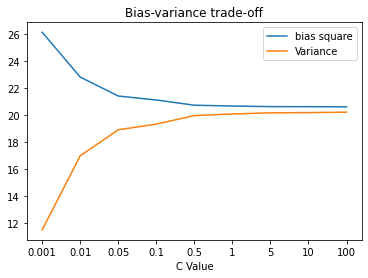

In [72]:
plt.figure()
plt.plot(bias_list, label='bias square')
plt.plot(variance_list,  label='Variance')
plt.xlabel('C Value')
plt.xticks(range(len([0.001,0.01,0.05,0.1,0.5,1,5,10, 100])), [0.001,0.01,0.05,0.1,0.5,1,5,10, 100])
plt.title('Bias-variance trade-off')
plt.legend()
plt.show()

In [73]:
MSE = pd.DataFrame(variance_list)+pd.DataFrame(bias_list)
MSE

,0
0,37.676561
1,39.846270
2,40.368717
3,40.494308
4,40.741600
5,40.798055
6,40.839831
7,40.855812
8,40.873521


By the plotting and the figure above, we find that we have lowest MSE at C=0.001. This means we have the best model when C=0.001. The reason why C=0.001 gives the best model is that:

MSE = bias square + variance + X

Based on Bias-variance trade-off plot, we can find that as bias decrease, the variance increase. As bias increases, the variance decreases.
So, in order to minimize the MSE, we must have a trade-off between bias and variance. And after the plotting and calculation, we find that when C=0.001, it gives minimum value of bias square + variance. As a result, C=0.001 gives the best model. 

# Model tuning

There are actually two hyperparameters in the logistic model: C value and solver. Solver includes 'newton-cg', 'lbfgs', 'liblinear', 'sag'
So, now, we add different solver and find which combinnation of C-value and solver gives the best model.

## Use accuracy as metric

In [74]:
logisitic_model = LogisticRegression(random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

# Change C value
logisitic_model = LogisticRegression(random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)


for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
        model = LogisticRegression(C=C, solver=solver, random_state=21, max_iter = 1000)
        accuracy = np.zeros(10)
        np_idx = 0
        print('C =',C,'solver = ',solver)
        for train_idx, test_idx in kfold.split(X_train_selected):
            X_train, X_val = X_train_selected.values[train_idx], X_train_selected.values[test_idx]
            Y_train, Y_val = Y_train_selected.values[train_idx], Y_train_selected.values[test_idx]
    
            probability_cumulative, probability_each, predictions= OrdinalLogistic(X_train, Y_train, X_val,model)
            
            
            TN = confusion_matrix(Y_val, predictions)[0][0]
            FP = confusion_matrix(Y_val, predictions)[0][1]
            FN = confusion_matrix(Y_val, predictions)[1][0]
            TP = confusion_matrix(Y_val, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
            if np.mean(accuracy) > best_accuracy:
                best_model = model
                best_params = {'C':C, 'solver':solver}
                best_accuracy = np.mean(accuracy)
                best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))
    

C = 0.001 solver =  newton-cg
C = 0.001 solver =  lbfgs
C = 0.001 solver =  liblinear
C = 0.001 solver =  sag
C = 0.01 solver =  newton-cg
C = 0.01 solver =  lbfgs
C = 0.01 solver =  liblinear
C = 0.01 solver =  sag
C = 0.05 solver =  newton-cg
C = 0.05 solver =  lbfgs
C = 0.05 solver =  liblinear
C = 0.05 solver =  sag
C = 0.1 solver =  newton-cg
C = 0.1 solver =  lbfgs
C = 0.1 solver =  liblinear
C = 0.1 solver =  sag
C = 0.5 solver =  newton-cg
C = 0.5 solver =  lbfgs
C = 0.5 solver =  liblinear
C = 0.5 solver =  sag
C = 1 solver =  newton-cg
C = 1 solver =  lbfgs
C = 1 solver =  liblinear
C = 1 solver =  sag
C = 5 solver =  newton-cg
C = 5 solver =  lbfgs
C = 5 solver =  liblinear
C = 5 solver =  sag
C = 10 solver =  newton-cg
C = 10 solver =  lbfgs
C = 10 solver =  liblinear
C = 10 solver =  sag
C = 100 solver =  newton-cg
C = 100 solver =  lbfgs
C = 100 solver =  liblinear
C = 100 solver =  sag
{'C': 5, 'solver': 'lbfgs'}
Best Score: 80.42%(2.222%)

The optimal log model uses C=5

## Use F1-score as metric

In [75]:
logisitic_model = LogisticRegression(random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_f1 = 0
best_f1_std = 0

# Change C value
logisitic_model = LogisticRegression(random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)


for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
        model = LogisticRegression(C=C, solver=solver, random_state=21, max_iter = 1000)
        f1= np.zeros(10)
        np_idx = 0
        print('C =',C,'solver = ',solver)
        for train_idx, test_idx in kfold.split(X_train_selected):
            X_train, X_val = X_train_selected.values[train_idx], X_train_selected.values[test_idx]
            Y_train, Y_val = Y_train_selected.values[train_idx], Y_train_selected.values[test_idx]
    
            probability_cumulative, probability_each, predictions= OrdinalLogistic(X_train, Y_train, X_val,model)
            
            f1_C = f1_score(Y_val,predictions, average='micro')

            f1[np_idx] = f1_C
            np_idx += 1
        
            if np.mean(f1) > best_f1:
                best_model = model
                best_params = {'C':C, 'solver':solver}
                best_f1 = np.mean(f1)
                best_f1_std = np.std(f1)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_f1*100,3),round(best_f1_std*100,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_f1*100,3),round(best_f1_std*100,3)))
           

C = 0.001 solver =  newton-cg
C = 0.001 solver =  lbfgs
C = 0.001 solver =  liblinear
C = 0.001 solver =  sag
C = 0.01 solver =  newton-cg
C = 0.01 solver =  lbfgs
C = 0.01 solver =  liblinear
C = 0.01 solver =  sag
C = 0.05 solver =  newton-cg
C = 0.05 solver =  lbfgs
C = 0.05 solver =  liblinear
C = 0.05 solver =  sag
C = 0.1 solver =  newton-cg
C = 0.1 solver =  lbfgs
C = 0.1 solver =  liblinear
C = 0.1 solver =  sag
C = 0.5 solver =  newton-cg
C = 0.5 solver =  lbfgs
C = 0.5 solver =  liblinear
C = 0.5 solver =  sag
C = 1 solver =  newton-cg
C = 1 solver =  lbfgs
C = 1 solver =  liblinear
C = 1 solver =  sag
C = 5 solver =  newton-cg
C = 5 solver =  lbfgs
C = 5 solver =  liblinear
C = 5 solver =  sag
C = 10 solver =  newton-cg
C = 10 solver =  lbfgs
C = 10 solver =  liblinear
C = 10 solver =  sag
C = 100 solver =  newton-cg
C = 100 solver =  lbfgs
C = 100 solver =  liblinear
C = 100 solver =  sag
{'C': 0.1, 'solver': 'lbfgs'}
Best Score: 41.246%(2.379%)

The optimal log model uses 

In [76]:
df.Q29_Encoded.value_counts()

0.0     3058
1.0      792
2.0      614
3.0      464
4.0      421
10.0     404
5.0      366
12.0     342
6.0      318
7.0      289
11.0     269
13.0     233
8.0      222
9.0      197
14.0     147
Name: Q29_Encoded, dtype: int64

We get the best model with C=0.1 and with 'lbfgs' solver. It has a cross validation score of 41.246% with a standard deviation of 2.379%

We find that the accuracy is high when we use accuracy as the metric. But we should not use accuracy as the metric as a suitable performance metric for this problem. Because:

We can find that most of the respondents' yearly compensation belongs to 0.0. We have imbalance data for this feature. This will lead to the data skewed. The model trainned based on this data will give the result prefer to group 0.0. The prediction will have bias. And it leads to the high score and low standard deviation. But these are wrong result due to the data skewed.
So we can't use accuracy cannot be a suitable performance metric. 

## Create the feature importance graph

In [77]:
importance_f1 = best_model.coef_
importance_f1 = pd.DataFrame(importance_f1)
importance_f1

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.003667,-0.102827,0.207934,0.094118,0.014799,0.164713,0.406105,0.183686,0.999308,0.462102,-0.460689,0.256663


In [78]:
importance_f1_list = [-0.003667, -0.102827, 0.207934, 0.094118, 0.014799, 0.164713, 0.406105, 0.183686, 0.999308, 0.462102, -0.460689, 0.256663]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

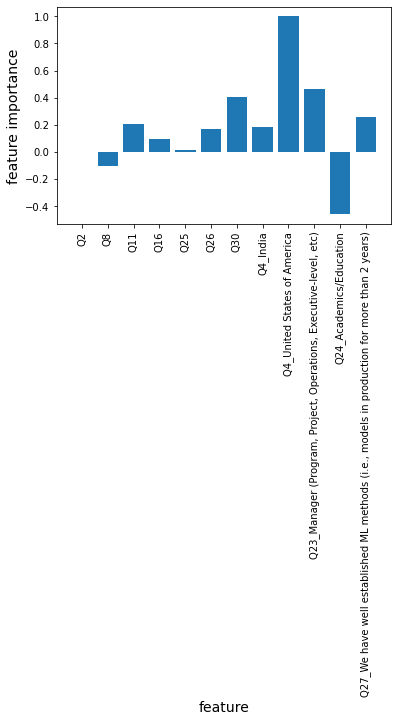

In [79]:
plt.bar(X_selected.columns,importance_f1_list)
plt.xlabel('feature', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.xticks(rotation=90)

# Testing & Discussion

We now know C=0.1, solver='lbfgs' gives the highest F1-score. And we use these two parameter values to build model and do test.

## Check underfitting or overfitting

In [80]:
# Compute the MSE for train set

logisitic_model = LogisticRegression(C=0.1, solver='lbfgs' ,random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)
f1_list = np.zeros(10)
mse_train_list = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X_train_selected):
    X_train, X_val = X_train_selected.values[train_idx], X_train_selected.values[test_idx]
    Y_train, Y_val = Y_train_selected.values[train_idx], Y_train_selected.values[test_idx]
    

    probability_cumulative, probability_each, predictions= OrdinalLogistic(X_train, Y_train, X_train,logisitic_model)

    f1 = f1_score(Y_train,predictions, average='micro')
    f1_list[np_idx] = f1
    mse = mean_squared_error(Y_train, predictions)
    mse_train_list[np_idx] = mse
    np_idx += 1

In [81]:
# Compute the MSE for test set

logisitic_model = LogisticRegression(C=0.1, solver='lbfgs' ,random_state=21, max_iter = 1000)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)
f1_list = np.zeros(10)
mse_test_list = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X_train_selected):
    X_train, X_val = X_train_selected.values[train_idx], X_train_selected.values[test_idx]
    Y_train, Y_val = Y_train_selected.values[train_idx], Y_train_selected.values[test_idx]
    

    probability_cumulative, probability_each, predictions= OrdinalLogistic(X_train, Y_train, X_test_selected,logisitic_model)

    f1 = f1_score(Y_test_selected,predictions, average='micro')
    f1_list[np_idx] = f1
    mse = mean_squared_error(Y_test, predictions)
    mse_test_list[np_idx] = mse
    np_idx += 1

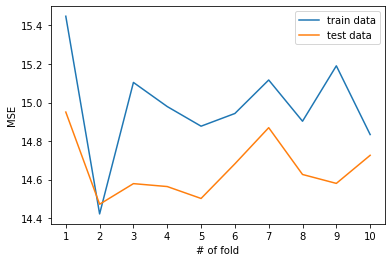

In [82]:
plt.figure()
plt.plot(mse_train_list, label='train data')
plt.plot(mse_test_list,  label='test data')
plt.xlabel('# of fold')
plt.xticks(range(len(range(1,11))), range(1,11))
plt.ylabel('MSE')
plt.legend()
plt.show()

As the plot shown above, the train data set has higher MSE than the test data set. So it is overfitting.  

## Optimal Model applied on train and test data

### Compute the F1 score

In [83]:
# Train
logisitic_model = LogisticRegression(C=0.1, solver='lbfgs' ,random_state=21, max_iter = 1000)
probability_cumulative, probability_each, predictions_train= OrdinalLogistic(X_train_selected, Y_train_selected, X_train_selected,logisitic_model)
f1_train_set = f1_score(Y_train_selected,predictions_train, average='micro')
print(f1_train_set)

0.41703248463564524


In [84]:
# Test
logisitic_model = LogisticRegression(C=0.1, solver='lbfgs' ,random_state=21, max_iter = 1000)
probability_cumulative, probability_each, predictions_test= OrdinalLogistic(X_train_selected, Y_train_selected, X_test_selected,logisitic_model)
f1_test_set = f1_score(Y_test_selected,predictions_test, average='micro')
print(f1_test_set)

0.40721015977058583


The train set F1 score is larger than the test set F1 score. So our model perform better on train set.

### Plot

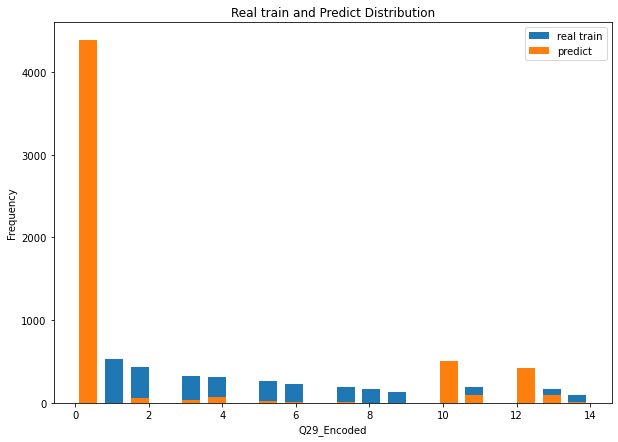

In [85]:
# Train
plt.figure(figsize = (10,7))
plt.hist(Y_train_selected, bins = 20,rwidth = 0.7, label = 'real train')
plt.hist(predictions_train, bins = 20,rwidth = 0.7, label = 'predict')
plt.xlabel('Q29_Encoded')
plt.ylabel('Frequency')
plt.title('Real train and Predict Distribution')
plt.legend()
plt.show()

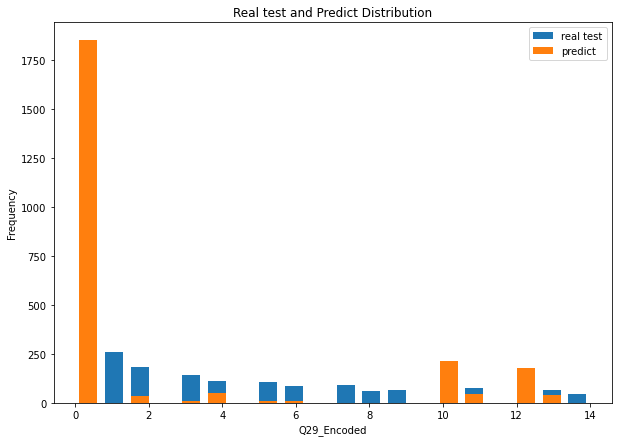

In [86]:
# Test
plt.figure(figsize = (10,7))
plt.hist(Y_test_selected, bins = 20,rwidth = 0.7, label = 'real test')
plt.hist(predictions_test, bins = 20,rwidth = 0.7, label = 'predict')
plt.xlabel('Q29_Encoded')
plt.ylabel('Frequency')
plt.title('Real test and Predict Distribution')
plt.legend()
plt.show()

The plots above shows that our model used on both train data and test data leads to silimlar result. Most of the predictions are on Q29_encoded=0, 10 and 12, which means that most of people have yearly compensation $0-999, $100,000-124,999 and $150,000-199,999. And Q29_encoded=0 has the most part.

Obviously, there is a bias. This may due to the imbalanced data set, which has more training data in Q29_encoded=0.
To improve the performance, we can add 'Other' value to the other value in Q29_encoded by reasonable proportion and then train model on this new data set.